## Test if networks derived from the elastic net are still associated with stress after correcting for age and sex

In [9]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm

out_dir = project_home+'/combinedDWI/network_analysis/ENET_results/'
sample_data = pd.read_csv(out_dir + 'full_sample_connectivity.csv', index_col=None)
stress_data = pd.read_csv(out_dir + 'labeling_results.csv',index_col=0)
full_data = sample_data.merge(stress_data,on='ID')
full_data = full_data[full_data['scan_age']>5.5]
full_data.columns

Index(['ID', 'default_default', 'default_dorsatt', 'default_frontoparietal',
       'default_limbic', 'default_somatomotor', 'default_ventatt',
       'default_visual', 'dorsatt_dorsatt', 'dorsatt_frontoparietal',
       'dorsatt_limbic', 'dorsatt_somatomotor', 'dorsatt_ventatt',
       'dorsatt_visual', 'frontoparietal_frontoparietal',
       'frontoparietal_limbic', 'frontoparietal_somatomotor',
       'frontoparietal_ventatt', 'frontoparietal_visual', 'limbic_limbic',
       'limbic_somatomotor', 'limbic_ventatt', 'limbic_visual',
       'somatomotor_somatomotor', 'somatomotor_ventatt', 'somatomotor_visual',
       'ventatt_ventatt', 'ventatt_visual', 'visual_visual', 'scan_age',
       'male', 'LEQ_tot_neg', 'LEQ_sumimp_neg', 'LEQ_tot_pos',
       'LEQ_sumimp_pos', 'LEQ_tot_noimp', 'LEQ_wprox_neg', 'LEQ_wprox_pos',
       'LEQ_tot_neg_prox1', 'LEQ_tot_neg_prox2', 'LEQ_tot_neg_prox3',
       'LEQ_tot_neg_infanttod03', 'LEQ_tot_neg_prek35', 'LEQ_tot_neg_school68',
       'LEQ_proxwto

In [12]:
## LEQ total negative life events (cummulative approach)
top = [ 'visual_visual','frontoparietal_somatomotor']

pvals = []
for net in top:
    model = smf.glm('{0} ~ LEQ_tot_neg_yj + male + scan_age'.format(net),data=full_data)
    model = model.fit()
    pvals.append(model.pvalues[1])
    print(model.summary())
print(pvals)

from statsmodels.stats.multitest import fdrcorrection
r,q = fdrcorrection(pvals,alpha=0.05,method='indep')
print(r)
print(q)

                 Generalized Linear Model Regression Results                  
Dep. Variable:          visual_visual   No. Observations:                   96
Model:                            GLM   Df Residuals:                       92
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                         0.64273
Method:                          IRLS   Log-Likelihood:                -112.96
Date:                Mon, 16 Nov 2020   Deviance:                       59.131
Time:                        13:32:07   Pearson chi2:                     59.1
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.5238      0.858      7.

In [13]:
## LEQ total negative life events, weighted by proximity of the event to the child (proximity approach)

top = ['visual_visual', 'frontoparietal_somatomotor']

pvals = []
for net in top:
    model = smf.glm('{0} ~ LEQ_wprox_neg_yj + male + scan_age'.format(net),data=full_data)
    model = model.fit()
    pvals.append(model.pvalues[1])
    print(model.summary())
print(pvals)
from statsmodels.stats.multitest import fdrcorrection
r,q = fdrcorrection(pvals,alpha=0.05,method='indep')
print(r)
print(q)

                 Generalized Linear Model Regression Results                  
Dep. Variable:          visual_visual   No. Observations:                   96
Model:                            GLM   Df Residuals:                       92
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                         0.64179
Method:                          IRLS   Log-Likelihood:                -112.89
Date:                Mon, 16 Nov 2020   Deviance:                       59.045
Time:                        13:32:41   Pearson chi2:                     59.0
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.5210      0.858  

## Conduct partial-eta models

In [16]:
# Create new totals variables for the partial eta models
full_data['LEQ_tot_neg_prox12'] = full_data['LEQ_tot_neg_prox1'] + full_data['LEQ_tot_neg_prox2']
full_data['LEQ_tot_neg_prox13'] = full_data['LEQ_tot_neg_prox1'] + full_data['LEQ_tot_neg_prox3']
full_data['LEQ_tot_neg_prox23'] = full_data['LEQ_tot_neg_prox2'] + full_data['LEQ_tot_neg_prox3']
full_data['LEQ_tot_neg_wprox12'] = full_data['LEQ_tot_neg_prox1']*3 + full_data['LEQ_tot_neg_prox2']*2
full_data['LEQ_tot_neg_wprox13'] = full_data['LEQ_tot_neg_prox1']*3 + full_data['LEQ_tot_neg_prox3']
full_data['LEQ_tot_neg_wprox23'] = full_data['LEQ_tot_neg_prox2']*2 + full_data['LEQ_tot_neg_prox3']

tf = PowerTransformer()

for a in ['LEQ_tot_neg_prox12','LEQ_tot_neg_prox13','LEQ_tot_neg_prox23','LEQ_tot_neg_wprox12','LEQ_tot_neg_wprox13',
          'LEQ_tot_neg_wprox23','LEQ_tot_neg_wprox12','LEQ_tot_neg_wprox13','LEQ_tot_neg_wprox23']:
    full_data[a + '_yj'] = tf.fit_transform(full_data[a].to_numpy().reshape(-1,1))

In [18]:
# Partial eta model for weighted sumsev neg

model = smf.ols('frontoparietal_somatomotor ~ LEQ_wprox_neg_yj',data=full_data)
model = model.fit()
print(model.summary())
rsq = model.rsquared
print('************** r-squared = {0}'.format(round(model.rsquared,3)))

model = smf.ols('frontoparietal_somatomotor ~ LEQ_tot_neg_wprox23_yj',data=full_data)
model = model.fit()
print(model.summary())
print('************** partial r-squared for prox 1 = {0}'.format(round(rsq-model.rsquared,3)))

model = smf.ols('frontoparietal_somatomotor ~ LEQ_tot_neg_wprox13_yj',data=full_data)
model = model.fit()
print(model.summary())
print('************** partial r-squared for prox 2 = {0}'.format(round(rsq-model.rsquared,3)))

model = smf.ols('frontoparietal_somatomotor ~ LEQ_tot_neg_wprox12_yj',data=full_data)
model = model.fit()
print(model.summary())
print('************** partial r-squared for prox 3 = {0}'.format(round(rsq-model.rsquared,3)))

                                OLS Regression Results                                
Dep. Variable:     frontoparietal_somatomotor   R-squared:                       0.067
Model:                                    OLS   Adj. R-squared:                  0.057
Method:                         Least Squares   F-statistic:                     6.757
Date:                        Mon, 16 Nov 2020   Prob (F-statistic):             0.0108
Time:                                13:34:30   Log-Likelihood:                -100.68
No. Observations:                          96   AIC:                             205.4
Df Residuals:                              94   BIC:                             210.5
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In [19]:
# run the partial eta models for the unweighted counts
top = ['visual_visual', 'frontoparietal_somatomotor']

for net in top:
    print('')
    print('################## {0} #####################'.format(net))
    print('')
    model = smf.ols('{0} ~ LEQ_tot_neg_yj'.format(net),data=full_data)
    model = model.fit()
    print(model.summary())
    rsq = model.rsquared
    print('************** r-squared = {0}'.format(round(model.rsquared,3)))
    
    model = smf.ols('{0} ~ LEQ_tot_neg_prox23_yj'.format(net),data=full_data)
    model = model.fit()
    print(model.summary())
    print('************** partial r-squared for prox 1 = {0}'.format(round(rsq-model.rsquared,3)))
    
    model = smf.ols('{0} ~ LEQ_tot_neg_prox13_yj'.format(net),data=full_data)
    model = model.fit()
    print(model.summary())
    print('************** partial r-squared for prox 2 = {0}'.format(round(rsq-model.rsquared,3)))
    
    model = smf.ols('{0} ~ LEQ_tot_neg_prox12_yj'.format(net),data=full_data)
    model = model.fit()
    print(model.summary())
    print('************** partial r-squared for prox 3 = {0}'.format(round(rsq-model.rsquared,3)))



################## visual_visual #####################

                            OLS Regression Results                            
Dep. Variable:          visual_visual   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     4.304
Date:                Mon, 16 Nov 2020   Prob (F-statistic):             0.0408
Time:                        13:34:51   Log-Likelihood:                -115.95
No. Observations:                  96   AIC:                             235.9
Df Residuals:                      94   BIC:                             241.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [21]:
for net in top:
    print('')
    print('################## {0} #####################'.format(net))
    print('')
    model = smf.ols('{0} ~ LEQ_wprox_neg_yj'.format(net),data=full_data)
    model = model.fit()
    print(model.summary())
    rsq = model.rsquared
    print('************** r-squared = {0}'.format(round(model.rsquared,3)))
    
    model = smf.ols('{0} ~ LEQ_tot_neg_wprox23_yj'.format(net),data=full_data)
    model = model.fit()
    print(model.summary())
    print('************** partial r-squared for prox 1 = {0}'.format(round(rsq-model.rsquared,3)))
    
    model = smf.ols('{0} ~ LEQ_tot_neg_wprox13_yj'.format(net),data=full_data)
    model = model.fit()
    print(model.summary())
    print('************** partial r-squared for prox 2 = {0}'.format(round(rsq-model.rsquared,3)))
    
    model = smf.ols('{0} ~ LEQ_tot_neg_wprox12_yj'.format(net),data=full_data)
    model = model.fit()
    print(model.summary())
    print('************** partial r-squared for prox 3 = {0}'.format(round(rsq-model.rsquared,3)))



################## visual_visual #####################

                            OLS Regression Results                            
Dep. Variable:          visual_visual   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     4.407
Date:                Mon, 16 Nov 2020   Prob (F-statistic):             0.0385
Time:                        13:35:27   Log-Likelihood:                -115.90
No. Observations:                  96   AIC:                             235.8
Df Residuals:                      94   BIC:                             240.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

## Conduct piece-wise regression modeling

In [27]:
tf = PowerTransformer()

for a in ['LEQ_tot_neg_infanttod03', 'LEQ_tot_neg_prek35', 'LEQ_tot_neg_school68',
          'LEQ_proxwtot_neg_infanttod03', 'LEQ_proxwtot_neg_prek35',
          'LEQ_proxwtot_neg_school68']:
    full_data[a + '_yj'] = tf.fit_transform(full_data[a].to_numpy().reshape(-1,1))

In [42]:
# test association between stress timing (cummulative) and network connectivity
top = ['visual_visual', 'frontoparietal_somatomotor']

for net in top:
    print('')
    print('################## {0} #####################'.format(net))
    print('')
    model = smf.ols('{0} ~ LEQ_tot_neg_infanttod03 + scan_age'.format(net),data=full_data)
    model = model.fit()
    print(model.summary())
    print('')
    model = smf.ols('{0} ~ LEQ_tot_neg_prek35 + scan_age'.format(net),data=full_data)
    model = model.fit()
    print(model.summary())


################## visual_visual #####################

                            OLS Regression Results                            
Dep. Variable:          visual_visual   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     2.861
Date:                Mon, 16 Nov 2020   Prob (F-statistic):             0.0623
Time:                        14:26:08   Log-Likelihood:                -115.23
No. Observations:                  96   AIC:                             236.5
Df Residuals:                      93   BIC:                             244.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [40]:
# test association between stress timing (proximity-weighted) and network connectivity
top = ['visual_visual', 'frontoparietal_somatomotor']

for net in top:
    print('')
    print('################## {0} #####################'.format(net))
    print('')
    model = smf.ols('{0} ~ LEQ_proxwtot_neg_infanttod03 + scan_age'.format(net),data=full_data)
    model = model.fit()
    print(model.summary())
    print('')
    model = smf.ols('{0} ~ LEQ_proxwtot_neg_prek35 + scan_age '.format(net),data=full_data)
    model = model.fit()
    print(model.summary())


################## visual_visual #####################

                            OLS Regression Results                            
Dep. Variable:          visual_visual   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     4.149
Date:                Mon, 16 Nov 2020   Prob (F-statistic):             0.0188
Time:                        14:24:08   Log-Likelihood:                -114.00
No. Observations:                  96   AIC:                             234.0
Df Residuals:                      93   BIC:                             241.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

## Plot figures

<Figure size 216x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

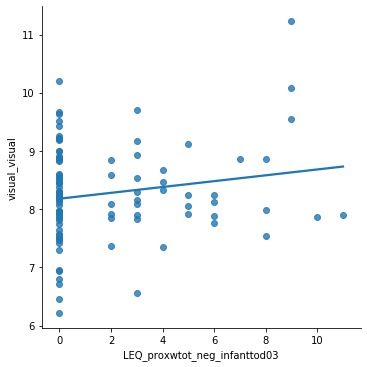

<Figure size 432x288 with 0 Axes>

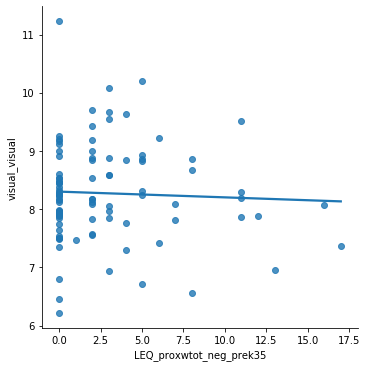

<Figure size 432x288 with 0 Axes>

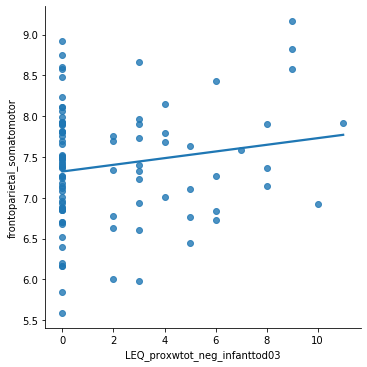

<Figure size 432x288 with 0 Axes>

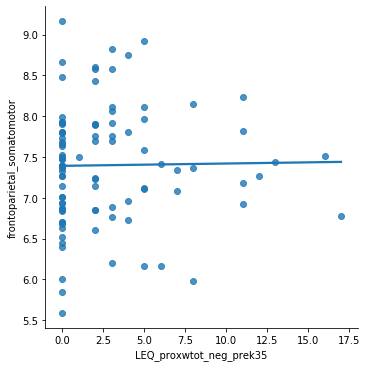

In [37]:
import seaborn as sns
figsize=(3,5)
plt.figure(figsize=figsize)

plt.figure()
sns.lmplot(x='LEQ_proxwtot_neg_infanttod03',y='visual_visual',data=full_data, ci=None)

plt.figure()
sns.lmplot(x='LEQ_proxwtot_neg_prek35',y='visual_visual',data=full_data, ci=None)

plt.figure()
sns.lmplot(x='LEQ_proxwtot_neg_infanttod03',y='frontoparietal_somatomotor',data=full_data, ci=None)

plt.figure()
sns.lmplot(x='LEQ_proxwtot_neg_prek35',y='frontoparietal_somatomotor',data=full_data, ci=None)


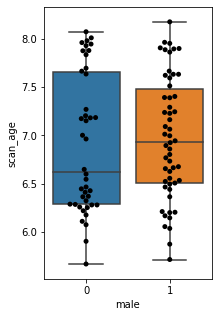

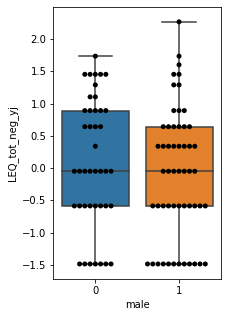

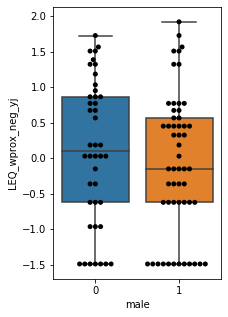

<Figure size 432x288 with 0 Axes>

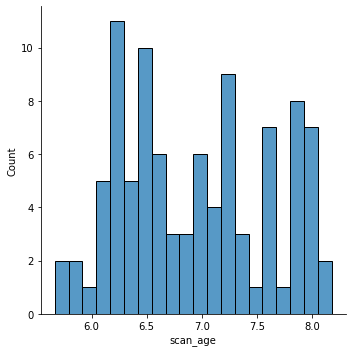

<Figure size 432x288 with 0 Axes>

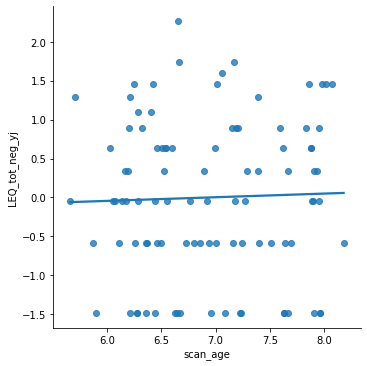

<Figure size 432x288 with 0 Axes>

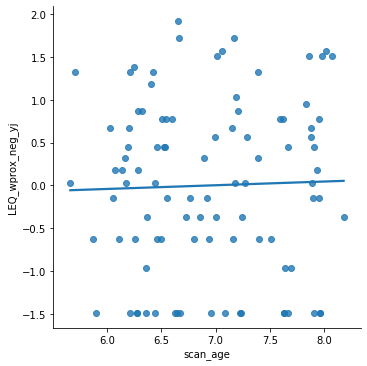

<Figure size 432x288 with 0 Axes>

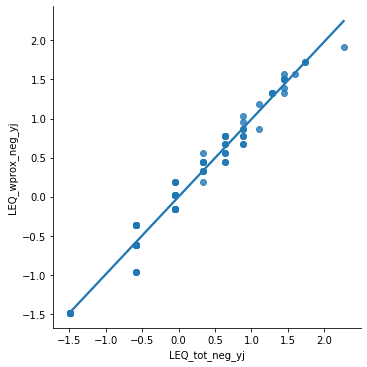

In [24]:
import seaborn as sns
figsize=(3,5)
plt.figure(figsize=figsize)
sns.boxplot(y='scan_age',x='male',data=full_data)
sns.swarmplot(y='scan_age',x='male',data=full_data, color='black')

plt.figure(figsize=figsize)
sns.boxplot(y='LEQ_tot_neg_yj',x='male',data=full_data)
sns.swarmplot(y='LEQ_tot_neg_yj',x='male',data=full_data, color='black')

plt.figure(figsize=figsize)
sns.boxplot(y='LEQ_wprox_neg_yj',x='male',data=full_data)
sns.swarmplot(y='LEQ_wprox_neg_yj',x='male',data=full_data, color='black')

plt.figure()
sns.displot(full_data['scan_age'],kind='hist',bins=20)

plt.figure()
sns.lmplot(y='LEQ_tot_neg_yj',x='scan_age',data=full_data, ci=None)

plt.figure()
sns.lmplot(y='LEQ_wprox_neg_yj',x='scan_age',data=full_data, ci=None)

plt.figure()
sns.lmplot(y='LEQ_wprox_neg_yj',x='LEQ_tot_neg_yj',data=full_data, ci=None)

<Figure size 432x288 with 0 Axes>

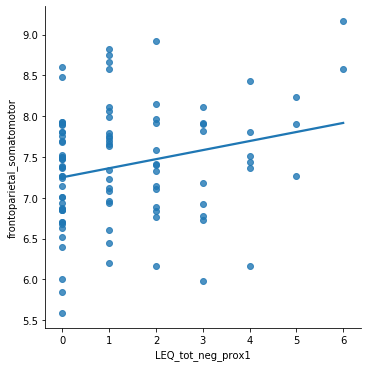

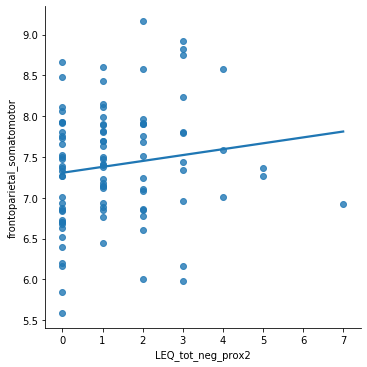

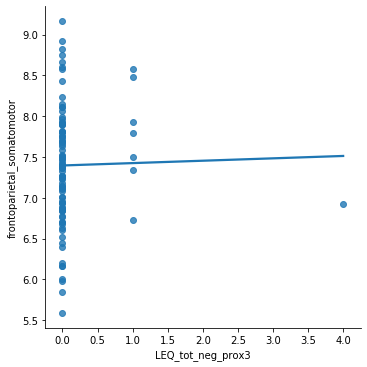

In [111]:
#for a in ['LEQ_tot_neg_prox12','LEQ_tot_neg_prox13','LEQ_tot_neg_prox23','LEQ_tot_neg_wprox12','LEQ_tot_neg_wprox13','LEQ_tot_neg_wprox23']:
plt.figure()
#sns.scatterplot(y='frontoparietal_somatomotor', x='LEQ_tot_neg',data=full_data)
sns.lmplot(y='frontoparietal_somatomotor', x='LEQ_tot_neg_prox1',data=full_data, ci=None)
sns.lmplot(y='frontoparietal_somatomotor', x='LEQ_tot_neg_prox2',data=full_data, ci=None)
sns.lmplot(y='frontoparietal_somatomotor', x='LEQ_tot_neg_prox3',data=full_data, ci=None)
plt.show()
plt.close()

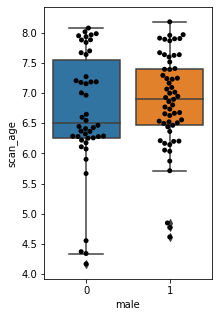

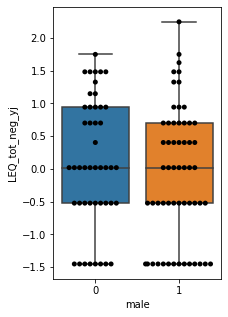

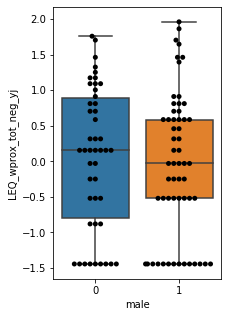

<Figure size 432x288 with 0 Axes>

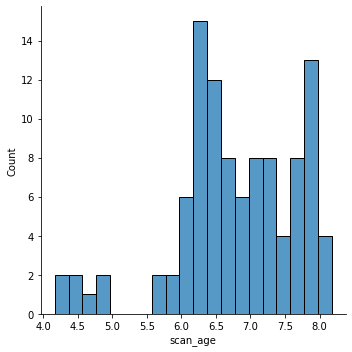

<Figure size 432x288 with 0 Axes>

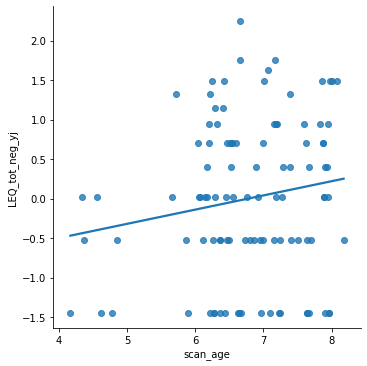

<Figure size 432x288 with 0 Axes>

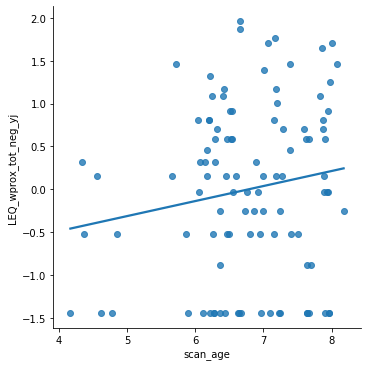

In [79]:
temp = pd.read_csv('/data/perlman/moochie/user_data/CamachoCat/combinedDWI/network_analysis/ENET_results_full/labeling_results.csv',index_col=None)
#temp = pd.read_csv(out_dir+'full_sample_connectivity.csv', index_col=None)
import seaborn as sns
figsize=(3,5)
plt.figure(figsize=figsize)
sns.boxplot(y='scan_age',x='male',data=temp)
sns.swarmplot(y='scan_age',x='male',data=temp, color='black')

plt.figure(figsize=figsize)
sns.boxplot(y='LEQ_tot_neg_yj',x='male',data=temp)
sns.swarmplot(y='LEQ_tot_neg_yj',x='male',data=temp, color='black')

plt.figure(figsize=figsize)
sns.boxplot(y='LEQ_wprox_tot_neg_yj',x='male',data=temp)
sns.swarmplot(y='LEQ_wprox_tot_neg_yj',x='male',data=temp, color='black')

plt.figure()
sns.displot(temp['scan_age'],kind='hist',bins=20)
plt.savefig('fulsamp_agedist.svg')

plt.figure()
sns.lmplot(y='LEQ_tot_neg_yj',x='scan_age',data=temp, ci=None)
plt.savefig('fulsamp_agestress.svg')

plt.figure()
sns.lmplot(y='LEQ_wprox_tot_neg_yj',x='scan_age',data=temp, ci=None)
